In [1]:
# Import of required libraries

import pandas as pd
import numpy as np
import math as mt
from datetime import date, datetime, timedelta
from IPython.display import clear_output
import scipy.stats as ss
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Get cwd as this changes depending on which laptop is being used.
# Import all required data from CSV files.

cw_directory = os.getcwd()

growth_data_path = f"{cw_directory}//growth_db.csv"
weather_data_path = f"{cw_directory}//weather_db.csv"
zone_data_path = f"{cw_directory}//zone_db.csv"
    
growth_data = pd.read_csv(growth_data_path)
weather_data = pd.read_csv(weather_data_path)
zone_data = pd.read_csv(zone_data_path)

In [3]:
# Ensure all data within a df is visible when printed.

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
# Variables used within script.

linearisation_coef = 0.625
stripping_coef = 0.92
min_grow_temp = 3
max_grow_temp = 27
future_days = 20
season = datetime(2021, 1, 1)

In [5]:
# Standardise weather data.

weather_data['date'] = pd.to_datetime(weather_data['date'], format='%d/%m/%Y')
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%H:%M:%S')
weather_data['day'] = weather_data.date.dt.day
weather_data['month'] = weather_data.date.dt.month
weather_data['day_month'] = weather_data['day'].astype(str) + " - " + weather_data['month'].astype(str)

weather_data['heat_units'] = weather_data['avg_temp'] - min_grow_temp
weather_data['heat_units'] = np.where((weather_data['heat_units'] < 0), 0, weather_data['heat_units'])
weather_data['heat_units'] = np.where((weather_data['heat_units'] > 24), 24, weather_data['heat_units']/24)

In [6]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66183 entries, 0 to 66182
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             66183 non-null  datetime64[ns]
 1   time             66183 non-null  datetime64[ns]
 2   avg_temp         66183 non-null  float64       
 3   rh               66183 non-null  float64       
 4   rain             66183 non-null  float64       
 5   solar_radiation  66183 non-null  float64       
 6   wind_speed_avg   66183 non-null  float64       
 7   wind_speed_gust  9951 non-null   float64       
 8   soil_temp        9951 non-null   float64       
 9   bat_volt         66183 non-null  float64       
 10  leaf_wet         60962 non-null  float64       
 11  dew_point        60962 non-null  float64       
 12  day              66183 non-null  int64         
 13  month            66183 non-null  int64         
 14  day_month        66183 non-null  objec

In [7]:
weather_data.head()

,date,time,avg_temp,rh,rain,solar_radiation,wind_speed_avg,wind_speed_gust,soil_temp,bat_volt,leaf_wet,dew_point,day,month,day_month,heat_units
0,2014-05-14,1900-01-01 14:00:00,15.8,55.9,0.0,457.0,2.7,NaN,NaN,6904.0,0.0,7.2,14,5,14 - 5,0.533333
1,2014-05-14,1900-01-01 15:00:00,17.0,51.2,0.0,1212.0,2.2,NaN,NaN,6952.0,0.0,7.0,14,5,14 - 5,0.583333
2,2014-05-14,1900-01-01 16:00:00,17.3,48.9,0.0,862.0,2.1,NaN,NaN,6922.0,0.0,6.6,14,5,14 - 5,0.595833
3,2014-05-14,1900-01-01 17:00:00,17.5,48.9,0.0,611.0,2.0,NaN,NaN,6904.0,0.0,6.7,14,5,14 - 5,0.604167
4,2014-05-14,1900-01-01 18:00:00,16.8,51.0,0.0,232.0,1.7,NaN,NaN,6894.0,0.0,6.7,14,5,14 - 5,0.575000


In [8]:
# Standardise growth data.

growth_data['sample_date'] = pd.to_datetime(growth_data['sample_date'], format='%d/%m/%Y')
growth_data['fieldzone'] = growth_data["field"] + " - " + growth_data["zone"].astype(str)
growth_data['stripped_diameter'] = growth_data['diameter'] * stripping_coef

In [9]:
growth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132055 entries, 0 to 132054
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   sample_date        132055 non-null  datetime64[ns]
 1   field              132055 non-null  object        
 2   zone               132055 non-null  int64         
 3   diameter           132055 non-null  float64       
 4   fieldzone          132055 non-null  object        
 5   stripped_diameter  132055 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 6.0+ MB


In [10]:
growth_data.head()

,sample_date,field,zone,diameter,fieldzone,stripped_diameter
0,2019-07-17,Allans 18,1,4.0,Allans 18 - 1,3.68
1,2019-07-17,Allans 18,1,3.0,Allans 18 - 1,2.76
2,2019-07-17,Allans 18,1,5.0,Allans 18 - 1,4.60
3,2019-07-17,Allans 18,1,5.0,Allans 18 - 1,4.60
4,2019-07-17,Allans 18,1,3.0,Allans 18 - 1,2.76


In [11]:
# Standardise zone data.

zone_data['planting_date'] = pd.to_datetime(zone_data['planting_date'], format='%d/%m/%Y')
zone_data['harvest_date'] = pd.to_datetime(zone_data['harvest_date'], format='%d/%m/%Y')
zone_data['zone'] = zone_data['zone'].astype(int)
zone_data["fieldzone"] = zone_data["field"] + " - " + zone_data["zone"].astype(str)
zone_data["fieldvariety"] = zone_data["field"] + " - " + zone_data["variety"]

In [12]:
zone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   field           755 non-null    object        
 1   zone            755 non-null    int32         
 2   planting_date   755 non-null    datetime64[ns]
 3   variety         755 non-null    object        
 4   method          755 non-null    object        
 5   inputs          755 non-null    object        
 6   protection      755 non-null    object        
 7   planting_rate   755 non-null    int64         
 8   sand            755 non-null    int64         
 9   silt            755 non-null    int64         
 10  clay            755 non-null    int64         
 11  organic_matter  755 non-null    float64       
 12  harvest_date    585 non-null    datetime64[ns]
 13  fieldzone       755 non-null    object        
 14  fieldvariety    755 non-null    object        
dtypes: dat

In [13]:
zone_data.head()

,field,zone,planting_date,variety,method,inputs,protection,planting_rate,sand,silt,clay,organic_matter,harvest_date,fieldzone,fieldvariety
0,Allans 07,1,2019-04-01,Krypton,Drilled,Conventional,Barley,249820,39,37,24,29.6,2019-12-15,Allans 07 - 1,Allans 07 - Krypton
1,Allans 07,2,2019-04-01,Krypton,Drilled,Conventional,Barley,249820,39,37,24,29.6,2019-12-15,Allans 07 - 2,Allans 07 - Krypton
2,Allans 07,3,2019-04-01,Longton,Drilled,Conventional,Barley,256524,39,37,24,29.6,2019-12-15,Allans 07 - 3,Allans 07 - Longton
3,Allans 07,4,2019-04-01,Longton,Drilled,Conventional,Barley,256524,39,37,24,29.6,2019-12-15,Allans 07 - 4,Allans 07 - Longton
4,Allans 07,5,2019-04-01,Batter,Drilled,Conventional,Barley,247048,39,37,24,29.6,2019-12-15,Allans 07 - 5,Allans 07 - Batter


In [14]:
# Start to build summary dataframe

summary_data = growth_data.copy()

summary_data["zone"] = summary_data["zone"].astype(str)
summary_data["fieldzone"] = summary_data["field"] + " - " + summary_data["zone"]
summary_data['fieldzonedate'] = summary_data['fieldzone'] + " - " + summary_data['sample_date'].astype(str)

summary_data = summary_data.set_index('fieldzone')
summary_data = summary_data.join(zone_data.set_index('fieldzone'), rsuffix = '_join')

summary_data['fieldvarietydate'] = summary_data['fieldvariety'] + " - " + summary_data['sample_date'].astype(str)
summary_data['heat_units'] = 0
summary_data['solar_radiation'] = 0

summary_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132055 entries, Allans 06 - 1 to Wissey O (S) - 3
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   sample_date        132055 non-null  datetime64[ns]
 1   field              132055 non-null  object        
 2   zone               132055 non-null  object        
 3   diameter           132055 non-null  float64       
 4   stripped_diameter  132055 non-null  float64       
 5   fieldzonedate      132055 non-null  object        
 6   field_join         132055 non-null  object        
 7   zone_join          132055 non-null  int32         
 8   planting_date      132055 non-null  datetime64[ns]
 9   variety            132055 non-null  object        
 10  method             132055 non-null  object        
 11  inputs             132055 non-null  object        
 12  protection         132055 non-null  object        
 13  planting_rate      132055 n

In [15]:
summary_data.head()

,sample_date,field,zone,diameter,stripped_diameter,fieldzonedate,field_join,zone_join,planting_date,variety,method,inputs,protection,planting_rate,sand,silt,clay,organic_matter,harvest_date,fieldvariety,fieldvarietydate,heat_units,solar_radiation
fieldzone,,,,,,,,,,,,,,,,,,,,,,,
Allans 06 - 1,2021-07-29,Allans 06,1,13.0,11.96,Allans 06 - 1 - 2021-07-29,Allans 06,1,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,NaT,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
Allans 06 - 1,2021-07-29,Allans 06,1,14.0,12.88,Allans 06 - 1 - 2021-07-29,Allans 06,1,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,NaT,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
Allans 06 - 1,2021-07-29,Allans 06,1,8.0,7.36,Allans 06 - 1 - 2021-07-29,Allans 06,1,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,NaT,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
Allans 06 - 1,2021-07-29,Allans 06,1,10.0,9.20,Allans 06 - 1 - 2021-07-29,Allans 06,1,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,NaT,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
Allans 06 - 1,2021-07-29,Allans 06,1,7.0,6.44,Allans 06 - 1 - 2021-07-29,Allans 06,1,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,NaT,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0


In [16]:
# Reset index and remove join columns from summary dataframe.

summary_data = summary_data.reset_index(inplace=False)
summary_data = summary_data.drop(columns=['field_join', 'zone_join'], inplace=False)
summary_data.head()

,fieldzone,sample_date,field,zone,diameter,stripped_diameter,fieldzonedate,planting_date,variety,method,inputs,protection,planting_rate,sand,silt,clay,organic_matter,harvest_date,fieldvariety,fieldvarietydate,heat_units,solar_radiation
0,Allans 06 - 1,2021-07-29,Allans 06,1,13.0,11.96,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,NaT,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
1,Allans 06 - 1,2021-07-29,Allans 06,1,14.0,12.88,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,NaT,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
2,Allans 06 - 1,2021-07-29,Allans 06,1,8.0,7.36,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,NaT,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
3,Allans 06 - 1,2021-07-29,Allans 06,1,10.0,9.20,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,NaT,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0
4,Allans 06 - 1,2021-07-29,Allans 06,1,7.0,6.44,Allans 06 - 1 - 2021-07-29,2021-04-10,Krypton,Drilled,Conventional,Barley,262270,40,41,19,24.6,NaT,Allans 06 - Krypton,Allans 06 - Krypton - 2021-07-29,0,0


In [17]:
def skewness(series):
    """Aggregate function to return skew of distribution"""
    return ss.skew(series, bias = False)

def kurt(series):
    """Aggregate function to return kurtosis of distribution"""
    return ss.kurtosis(series, bias = False)

In [18]:
# Aggregation of summary data to which can be used to fit models.
# Non aggregated data can also be used to fit models but it will be more difficult to create a predicted distribution...
# cont... due to not having a standard deviation variable which is generated during aggregation.

summary_data_avg = summary_data.copy()

summary_data_avg = summary_data_avg.groupby(['fieldzonedate']).agg({'stripped_diameter' : ['mean', 'std', 'count', skewness, kurt],
                                                                'method' : ['first'],
                                                                'inputs' : ['first'],
                                                                'variety' : ['first'],
                                                                'protection' : ['first'],
                                                                'sand' : ['mean'],
                                                                'silt' : ['mean'],
                                                                'clay' : ['mean'],
                                                                'organic_matter' : ['mean'],
                                                                'planting_date' : ['first'],
                                                                'sample_date' : ['first'],
                                                                'fieldzone' : ['first']}).reset_index()

summary_data_avg.columns = ['fieldzonedate',
                            'mean_diameter',
                            'std_dev_diameter',
                            'pp2m2',
                            'skewness',
                            'kurtosis',
                            'method',
                            'inputs',
                            'variety',
                            'protection',
                            'sand',
                            'silt',
                            'clay',
                            'organic_matter',
                            'planting_date',
                            'sample_date',
                            'fieldzone']

summary_data_avg['d_lin'] = (summary_data_avg['mean_diameter'])**linearisation_coef
summary_data_avg['s_lin'] = (summary_data_avg['std_dev_diameter'])**linearisation_coef
summary_data_avg['heat_units'] = 0
summary_data_avg['solar_radiation'] = 0

summary_data_avg.tail()

,fieldzonedate,mean_diameter,std_dev_diameter,pp2m2,skewness,kurtosis,method,inputs,variety,protection,sand,silt,clay,organic_matter,planting_date,sample_date,fieldzone,d_lin,s_lin,heat_units,solar_radiation
3358,Wissey O (S) - 1 - 2019-09-19,34.209474,5.277874,38,-0.366295,-0.436126,Drilled,Conventional,Shafton,Barley,11,64,25,71.2,2019-03-26,2019-09-19,Wissey O (S) - 1,9.095812,2.828374,0,0
3359,Wissey O (S) - 2 - 2019-07-30,18.447179,3.409484,39,0.261426,0.527252,Drilled,Conventional,Shafton,Barley,11,64,25,71.2,2019-03-26,2019-07-30,Wissey O (S) - 2,6.183099,2.152437,0,0
3360,Wissey O (S) - 2 - 2019-09-19,30.631818,4.797228,44,-0.065718,-0.292600,Drilled,Conventional,Shafton,Barley,11,64,25,71.2,2019-03-26,2019-09-19,Wissey O (S) - 2,8.489028,2.664520,0,0
3361,Wissey O (S) - 3 - 2019-07-30,20.079000,2.996661,40,0.333063,-0.493385,Drilled,Conventional,Shafton,Barley,11,64,25,71.2,2019-03-26,2019-07-30,Wissey O (S) - 3,6.519493,1.985631,0,0
3362,Wissey O (S) - 3 - 2019-09-19,29.920909,3.829350,44,-0.133634,-0.709054,Drilled,Conventional,Shafton,Barley,11,64,25,71.2,2019-03-26,2019-09-19,Wissey O (S) - 3,8.365352,2.314479,0,0


In [19]:
# Aggregation of weather data to create a more manageable dataframe as we only need day by day accuracy not hour by hour.

weather_data_avg = weather_data.copy()

weather_data_avg = weather_data_avg.groupby(['date']).agg({'rain' : ['sum'],
                                                       'heat_units' : ['sum'],
                                                       'solar_radiation' : ['sum'],
                                                       'wind_speed_avg' : ['mean'],
                                                       'rh' : ['mean'],
                                                       'avg_temp' : ['mean']}).reset_index()

weather_data_avg.columns = ['date',
                            'rain',
                            'heat_units',
                            'solar_radiation',
                            'wind_speed_avg',
                            'rh',
                            'avg_temp']

weather_data_avg['day'] = weather_data_avg.date.dt.day
weather_data_avg['month'] = weather_data_avg.date.dt.month
weather_data_avg['day_month'] = weather_data_avg['day'].astype(str) + " - " + weather_data_avg['month'].astype(str)

# Further aggregation of weather to get the average weather for a given day and a given month, regardless of the year.
# This average weather will be used to predict heat and solar that a plant will receive.
# Could possibly introduce some sort of short term weather forecast here???

weather_data_avg_group = weather_data_avg.copy()

weather_data_avg_group = weather_data_avg_group.groupby(['day_month']).agg({'rain' : ['mean'],
                                                                            'heat_units' : ['mean'],
                                                                            'solar_radiation' : ['mean'],
                                                                            'wind_speed_avg' : ['mean'],
                                                                            'rh' : ['mean'],
                                                                            'avg_temp' : ['mean']}).reset_index()

weather_data_avg_group.columns = ['day_month',
                                  'rain',
                                  'heat_units',
                                  'solar_radiation',
                                  'wind_speed_avg',
                                  'rh',
                                  'avg_temp']

max_date = max(weather_data_avg.date)

for i in range(1, 300):
    
    clear_output(wait=True)
    
    date = max_date + timedelta(days=i)
    weather_data_avg = weather_data_avg.append({'date': date,
                                                'rain': np.nan,
                                                'heat_units':np.nan,
                                                'solar_radiation':np.nan,
                                                'wind_speed_avg':np.nan,
                                                'rh':np.nan,
                                                'avg_temp':np.nan }, ignore_index=True)
    
    print("Current Progress:", np.round(i/300*100,0),"%")
    
weather_data_avg['day'] = weather_data_avg.date.dt.day
weather_data_avg['month'] = weather_data_avg.date.dt.month
weather_data_avg['day_month'] = weather_data_avg['day'].astype(str) + " - " + weather_data_avg['month'].astype(str)  

Current Progress: 100.0 %


In [20]:
###THIS IS A VERY SLOW PROCESS (COULD PARALLEL PROCESSING BE INTRODUCED???)

def mean_weather(day_month, variable):
    df = weather_data_avg_group[weather_data_avg_group['day_month']==day_month]
    weather_value = df[variable].sum()
    return weather_value

for variable in ['rain', 'heat_units', 'solar_radiation', 'wind_speed_avg', 'rh', 'avg_temp']:
    for i in weather_data_avg.index:
        
        clear_output(wait=True)
        
        if weather_data_avg[variable][i] == np.nan:
            test = 'test'
            
        else:
            day_month = weather_data_avg['day_month'][i]
            weather_data_avg[variable][i] = mean_weather(day_month, variable)
            
        print(f"{variable} progress:", np.round(i/len(weather_data_avg)*100,0),"%")
    
weather_data_avg.tail()

avg_temp progress: 100.0 %


,date,rain,heat_units,solar_radiation,wind_speed_avg,rh,avg_temp,day,month,day_month
3052,2022-09-21,1.7375,10.858333,5666.260,3.513021,83.860938,13.858333,21,9,21 - 9
3053,2022-09-22,0.4125,10.211458,5773.990,2.764948,86.504167,13.211458,22,9,22 - 9
3054,2022-09-23,3.4625,10.481771,5300.260,4.462656,85.864583,13.481771,23,9,23 - 9
3055,2022-09-24,2.6625,10.228125,5940.990,3.801562,85.066146,13.228125,24,9,24 - 9
3056,2022-09-25,0.8625,10.028125,4829.715,2.846615,87.015625,12.953125,25,9,25 - 9


In [21]:
weather_data_avg.tail()

,date,rain,heat_units,solar_radiation,wind_speed_avg,rh,avg_temp,day,month,day_month
3052,2022-09-21,1.7375,10.858333,5666.260,3.513021,83.860938,13.858333,21,9,21 - 9
3053,2022-09-22,0.4125,10.211458,5773.990,2.764948,86.504167,13.211458,22,9,22 - 9
3054,2022-09-23,3.4625,10.481771,5300.260,4.462656,85.864583,13.481771,23,9,23 - 9
3055,2022-09-24,2.6625,10.228125,5940.990,3.801562,85.066146,13.228125,24,9,24 - 9
3056,2022-09-25,0.8625,10.028125,4829.715,2.846615,87.015625,12.953125,25,9,25 - 9


In [22]:
def cumulative_weather(start, finish, weather_variable, weather_data):
    """Function used to find the cumulative weather input between 2 given dates"""
    df = weather_data.loc[(weather_data['date'] > start) & (weather_data['date'] < finish), [weather_variable]]
    total_units = df[weather_variable].sum()
    return total_units

In [23]:
for i in summary_data_avg.index:
    clear_output(wait=True)
    
    planting_date = summary_data_avg['planting_date'][i]
    sample_date = summary_data_avg['sample_date'][i]
    summary_data_avg['solar_radiation'][i] = cumulative_weather(planting_date, sample_date, 'solar_radiation', weather_data_avg)
    
    print("Current Progress:", np.round(i/len(summary_data_avg)*100,0),"%")

Current Progress: 100.0 %


In [24]:
for i in summary_data_avg.index:
    clear_output(wait=True)
    
    planting_date = summary_data_avg['planting_date'][i]
    sample_date = summary_data_avg['sample_date'][i]
    summary_data_avg['heat_units'][i] = cumulative_weather(planting_date, sample_date, 'heat_units', weather_data_avg)
    
    print("Current Progress:", np.round(i/len(summary_data_avg)*100,0),"%")

Current Progress: 100.0 %


In [25]:
#Dummy code for protection column while retaining the original 'protection' series within the dataframe for visualisation purposes.

summary_data_avg['protection_2'] = summary_data_avg['protection'].copy()
summary_data_avg = pd.get_dummies(summary_data_avg, columns = ['protection'], drop_first = False)
summary_data_avg.rename(columns={'protection_2': 'protection'}, inplace=True)

In [26]:
summary_data_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3363 entries, 0 to 3362
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fieldzonedate      3363 non-null   object        
 1   mean_diameter      3363 non-null   float64       
 2   std_dev_diameter   3363 non-null   float64       
 3   pp2m2              3363 non-null   int64         
 4   skewness           3363 non-null   float64       
 5   kurtosis           3363 non-null   float64       
 6   method             3363 non-null   object        
 7   inputs             3363 non-null   object        
 8   variety            3363 non-null   object        
 9   sand               3363 non-null   int64         
 10  silt               3363 non-null   int64         
 11  clay               3363 non-null   int64         
 12  organic_matter     3363 non-null   float64       
 13  planting_date      3363 non-null   datetime64[ns]
 14  sample_d

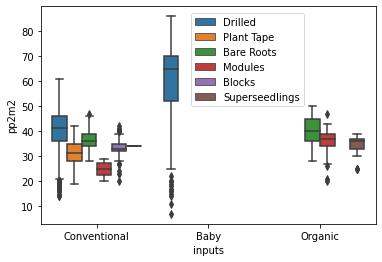

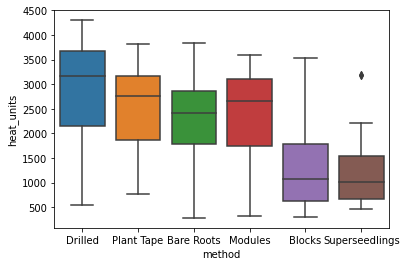

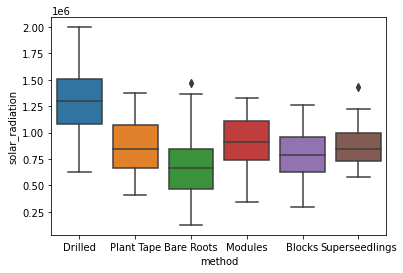

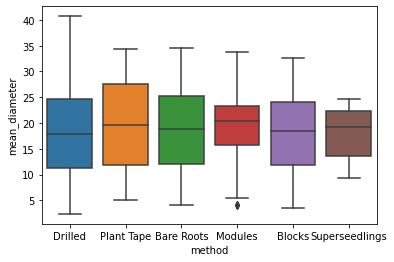

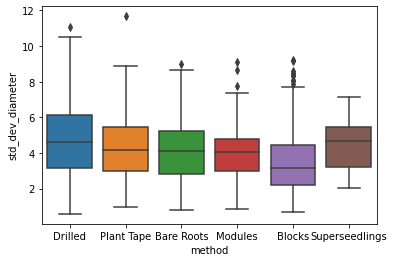

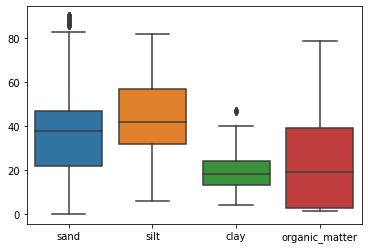

In [79]:
# Box plots to check for outliers in continuous variables of importance.

sns.boxplot(x = 'inputs', y = 'pp2m2', data = summary_data_avg, hue = 'method', orient = 'v')
plt.legend(bbox_to_anchor=(0.45, 0.97), loc='upper left', borderaxespad=0)
plt.show()

sns.boxplot(x = 'method', y = 'heat_units', data = summary_data_avg, orient = 'v')
plt.show()

sns.boxplot(x = 'method', y = 'solar_radiation', data = summary_data_avg, orient = 'v')
plt.show()

sns.boxplot(x = 'method', y = 'mean_diameter', data = summary_data_avg, orient = 'v')
plt.show()

sns.boxplot(x = 'method', y = 'std_dev_diameter', data = summary_data_avg, orient = 'v')
plt.show()

sns.boxplot(data = summary_data_avg[['sand', 'silt', 'clay', 'organic_matter']])
plt.show()

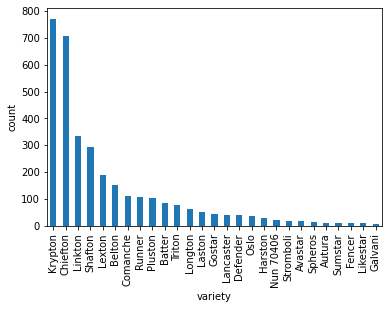

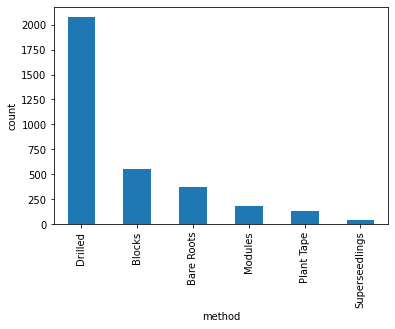

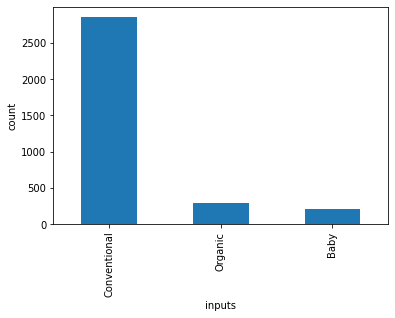

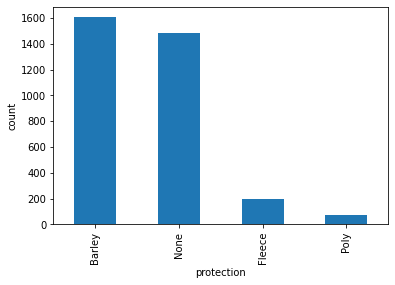

In [90]:
# Value counts of categorical variables of importance.

summary_data_avg['variety'].value_counts().plot(kind = 'bar', xlabel = 'variety', ylabel = 'count')
plt.show()

summary_data_avg['method'].value_counts().plot(kind = 'bar', xlabel = 'method', ylabel = 'count')
plt.show()

summary_data_avg['inputs'].value_counts().plot(kind = 'bar', xlabel = 'inputs', ylabel = 'count')
plt.show()

summary_data_avg['protection'].value_counts().plot(kind = 'bar', xlabel = 'protection', ylabel = 'count')
plt.show()


In [28]:
# Check for any null values and if any are present, find out why.

summary_data_avg[summary_data_avg.isna().any(axis=1)]summary_data_avg

,fieldzonedate,mean_diameter,std_dev_diameter,pp2m2,skewness,kurtosis,method,inputs,variety,sand,silt,clay,organic_matter,planting_date,sample_date,fieldzone,d_lin,s_lin,heat_units,solar_radiation,protection,protection_Barley,protection_Fleece,protection_None,protection_Poly


In [29]:
#Remove any null values to prevent failure but if any are present, it's essential to find out why.

summary_data_avg = summary_data_avg.dropna()

In [30]:
def average_count(fieldzone, df_1 = summary_data_avg):
    """Function used to find the average plants per two meters squared from every sample from a given fieldzone over the entire season"""
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    average_count = df_1['pp2m2'].mean()
    
    if mt.isnan(average_count):
        average_count = 40
      
    return average_count

average_count('RH33 - 1')

36.333333333333336

In [31]:
def max_sample_date(fieldzone, df_1 = summary_data_avg, df_2 = zone_data):
    """Function used to find the most recent sample date for a given fieldzone"""
    
    df_1 = df_1[df_1['fieldzone'] == fieldzone]
    max_sample_date = max(df_1['sample_date'], default = 0)
    if max_sample_date == 0:
        df_2 = df_2[df_2['fieldzone'] == fieldzone]
        max_sample_date = df_2['planting_date'].max()
    
    return max_sample_date

max_sample_date('RH33 - 1')

Timestamp('2021-11-18 00:00:00')

In [32]:
def max_mean_diameter_lin(fieldzone, df_1 = summary_data_avg):
    """Function used to find the mean diameter of the sample at the most recent sample date"""
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_mean_diameter = df_1['mean_diameter'].max()
    max_mean_diameter_lin = max_mean_diameter ** linearisation_coef
    
    if mt.isnan(max_mean_diameter_lin):
        max_mean_diameter_lin = 0
    
    return max_mean_diameter_lin

max_mean_diameter_lin('Allans 07 - 1')

9.26293214352213

In [33]:
def max_std_dev_diameter_lin(fieldzone, df_1 = summary_data_avg):
    """Function used to find the standard deviation of the sample at the most recent sample date"""
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_std_dev_diameter = df_1['std_dev_diameter'].max()
    max_std_dev_diameter_lin = max_std_dev_diameter ** linearisation_coef
    
    if mt.isnan(max_std_dev_diameter_lin):
        max_std_dev_diameter_lin = 0
    
    return max_std_dev_diameter_lin

max_std_dev_diameter_lin('Allans 07 - 1')

4.348294771174176

In [34]:
def max_solar(fieldzone, df_1 = summary_data_avg):
    """Function used to find the solar radiation received at the most recent sample date"""
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_solar = df_1['solar_radiation'].max()
    
    if mt.isnan(max_solar):
        max_solar = 0
    
    return max_solar

max_solar('Allans 07 - 1')

1761976

In [35]:
def max_heat(fieldzone, df_1 = summary_data_avg):
    """Function used to find the heat units received at the most recent sample date"""
    
    df_1 = df_1[df_1['fieldzone']==fieldzone]
    max_heat = df_1['heat_units'].max()
    
    if mt.isnan(max_heat):
        max_heat = 0
    
    return max_heat

max_heat('Allans 07 - 1')

4078

In [36]:
def filter_data(data, method, inputs, variety):
    """Function used to filter df so it only contains a single variety, input & method"""
    
    filtered = data[data['variety'].str.contains(variety)]
    filtered = filtered[filtered['inputs'].str.contains(inputs)]
    filtered = filtered[filtered['method'].str.contains(method)]
    
    return filtered

In [37]:
def predict_weather(start, finish, variable, df_1 = weather_data):
    """Function used to calculated a predicted weather variable for a given timeframe"""
    
    df_1 = df_1.loc[(df_1['date'] > start) & (df_1['date'] < finish), [variable]]
    predicted_weather= df_1[variable].sum()
    
    return predicted_weather

start = datetime(year=2021, month=6, day=2, hour=13, minute=14, second=31)
finish = datetime(year=2022, month=6, day=2, hour=13, minute=14, second=31)

predict_weather(start, finish, 'rain')

374.0

In [38]:
# This df will be used for Linear Regression model. Prediction will be taken from the most recent (maximum) sample date...
# The 'max' variables just indicate the result of the most recent sample at that zone.

zone_data['mean_pp2m2'] = 0.0
zone_data['max_sample_date'] = 0
zone_data['max_mean_diameter_lin'] = 0.0
zone_data['max_std_dev_diameter_lin'] = 0.0
zone_data['max_heat'] = 0.0
zone_data['max_solar'] = 0.0
zone_data['remaining_heat'] = 0.0
zone_data['remaining_solar'] = 0.0

for i in zone_data.index:
    
    clear_output(wait=True)
    
    fieldzone = zone_data.loc[i, 'fieldzone']
    zone_data.loc[i, 'mean_pp2m2'] = average_count(fieldzone)
    zone_data.loc[i, 'max_sample_date'] = max_sample_date(fieldzone)
    zone_data.loc[i, 'max_mean_diameter_lin'] = max_mean_diameter_lin(fieldzone)
    zone_data.loc[i, 'max_std_dev_diameter_lin'] = max_std_dev_diameter_lin(fieldzone)
    zone_data.loc[i, 'max_heat'] = max_heat(fieldzone)
    zone_data.loc[i, 'max_solar'] = max_solar(fieldzone)
    start = zone_data.loc[i, 'max_sample_date']
    today = datetime.today() + timedelta(days=future_days)
    finish = today.strftime("%d/%m/%Y")
    zone_data.loc[i, 'remaining_heat'] = cumulative_weather(start, finish, 'heat_units', weather_data_avg)
    zone_data.loc[i, 'remaining_solar'] = cumulative_weather(start, finish, 'solar_radiation', weather_data_avg)   
    
    print("Current Progress:", np.round(i/len(zone_data)*100,0),"%")
    
zone_data['establishment'] = (zone_data['mean_pp2m2']/2*10000)/zone_data['planting_rate']
zone_data['est_mean_diameter_gain'] = 0.0
zone_data['est_std_dev_diameter_gain'] = 0.0
zone_data['est_mean_diameter'] = 0.0
zone_data['est_std_dev_diameter'] = 0.0


Current Progress: 100.0 %


In [39]:
# Check to see samples with highest mean diameters

summary_data_avg.sort_values(by='mean_diameter', ascending=False).head()

,fieldzonedate,mean_diameter,std_dev_diameter,pp2m2,skewness,kurtosis,method,inputs,variety,sand,silt,clay,organic_matter,planting_date,sample_date,fieldzone,d_lin,s_lin,heat_units,solar_radiation,protection,protection_Barley,protection_Fleece,protection_None,protection_Poly
397,Garretts Decoy 3 - 3 - 2019-11-19,40.725333,7.227684,30,-0.073793,-0.687747,Drilled,Conventional,Linkton,21,64,15,77.9,2019-03-25,2019-11-19,Garretts Decoy 3 - 3,10.142976,3.442504,3933,1748523,Barley,1,0,0,0
2364,Park Farm 50 - 1 - 2019-11-25,38.477647,6.569999,34,-0.166278,0.000815,Drilled,Conventional,Krypton,27,42,31,48.7,2019-03-22,2019-11-25,Park Farm 50 - 1,9.789383,3.243234,3966,1776225,Barley,1,0,0,0
400,Garretts Decoy 3 - 4 - 2019-11-19,37.996000,7.011300,30,0.065968,-0.017297,Drilled,Conventional,Linkton,21,64,15,77.9,2019-03-25,2019-11-19,Garretts Decoy 3 - 4,9.712615,3.377724,3933,1748523,Barley,1,0,0,0
394,Garretts Decoy 3 - 2 - 2019-11-19,37.260000,6.544521,30,0.662611,0.111289,Drilled,Conventional,Linkton,21,64,15,77.9,2019-03-25,2019-11-19,Garretts Decoy 3 - 2,9.594598,3.235368,3933,1748523,Barley,1,0,0,0
391,Garretts Decoy 3 - 1 - 2019-11-19,37.076000,7.200240,30,-0.077724,0.660048,Drilled,Conventional,Linkton,21,64,15,77.9,2019-03-25,2019-11-19,Garretts Decoy 3 - 1,9.564958,3.434329,3933,1748523,Barley,1,0,0,0
